In [1]:
from pathlib import Path
import time
import IPython
from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"

In [2]:
drive.mount('/content/drive/')
DATASET_DIR = Path().cwd() / "drive" / "MyDrive" / "CSE428" / "dataset"

Mounted at /content/drive/


In [3]:
# Hyperparameters
AUTOTUNE = tf.data.AUTOTUNE
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 256
HEIGHT, WIDTH = 64, 64
NUM_CLASSES = 5
LR = 1e-3
EPOCHS = 80

# Directories
TRAIN_DIR = DATASET_DIR / "train"
TEST_DIR = DATASET_DIR / "test"

num_of_val_files = sum(path.is_file() for path in Path(TRAIN_DIR).rglob("*"))

In [ ]:
class_names = ["bighorn", "butterfly", "camel", "chimpanzee", "pig"]

ds_train = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=True,
    seed=47,
    validation_split=VALIDATION_SPLIT,
    subset="training",
)

ds_val = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=True,
    seed=47,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
)

ds_test = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=num_of_val_files,
    image_size=(HEIGHT, WIDTH),
    shuffle=True,
    seed=47,
)

Found 2164 files belonging to 5 classes.
Using 1732 files for training.
Found 2164 files belonging to 5 classes.
Using 432 files for validation.
Found 250 files belonging to 5 classes.


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
standardize_image = tf.image.per_image_standardization
normalization = keras.layers.Rescaling(1./255)

ds_train = ds_train.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(lambda x, y: (standardize_image(x), y), num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)

ds_val = ds_val.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(lambda x, y: (standardize_image(x), y), num_parallel_calls=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

ds_test = ds_test.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(lambda x, y: (standardize_image(x), y), num_parallel_calls=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def define_model(img_height, img_width, num_classes):
    inputs = tf.keras.Input(shape=(img_height, img_width, 3), name="images")
    flatten = tf.keras.layers.Flatten(
        input_shape=(img_height, img_width, 3), name="input_layer"
    )(inputs)

    h1 = tf.keras.layers.Dense(
        512, activation="selu", kernel_initializer="lecun_normal", name="hidden_layer_1"
    )(flatten)
    h2 = tf.keras.layers.Dense(
        256, activation="selu", kernel_initializer="lecun_normal", name="hidden_layer_2"
    )(h1)
    h3 = tf.keras.layers.Dense(
        128, activation="selu", kernel_initializer="lecun_normal", name="hidden_layer_3"
    )(h2)

    outputs = tf.keras.layers.Dense(
        num_classes, activation="softmax", name="predictions"
    )(h3)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 64, 64, 3)]       0         
                                                                 
 input_layer (Flatten)       (None, 12288)             0         
                                                                 
 hidden_layer_1 (Dense)      (None, 512)               6291968   
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               131328    
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               32896     
                                                                 
 predictions (Dense)         (None, 5)                 645       
                                                                 
Total params: 6456837 (24.63 MB)
Trainable params: 6456837 (2

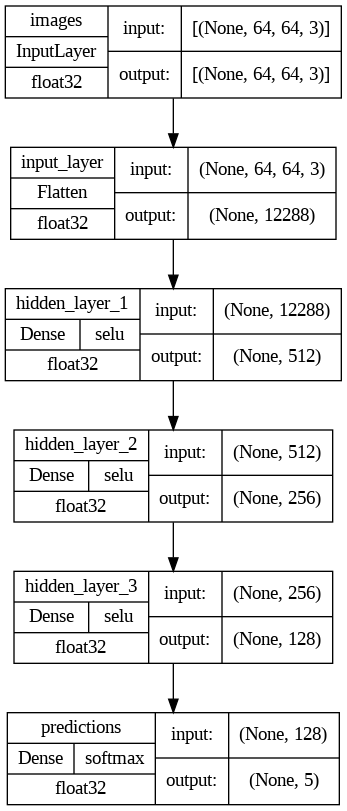

In [ ]:
model = define_model(HEIGHT, WIDTH, NUM_CLASSES)
model.summary()
keras.utils.plot_model(
    model, show_shapes=True, show_dtype=True, show_layer_activations=True
)

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=LR, momentum=0.9, nesterov=True)
loss_fn = keras.losses.CategoricalCrossentropy()

train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        probabilities = model(x, training=True)
        loss_value = loss_fn(y, probabilities)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, probabilities)
    return loss_value

In [ ]:
@tf.function
def val_step(x, y):
    val_probabilities = model(x, training=False)
    val_acc_metric.update_state(y, val_probabilities)

In [ ]:
for epoch in range(EPOCHS):
    print(f"Start of Epoch {epoch}")
    start_time = time.time()

    for step, (x_batch_train, y_batch_train) in enumerate(ds_train):
        loss_value = train_step(x_batch_train, y_batch_train)

        if step % 200 == 0:
            print(
                f"Training loss (for one batch) at step {step}: {float(loss_value):.4f}"
            )
            print(f"Seen so far: {(step + 1) * BATCH_SIZE} samples")

    train_acc = train_acc_metric.result()
    print(f"Training acc over epoch: {float(train_acc):.4f}")

    train_acc_metric.reset_states()

    for x_batch_val, y_batch_val in ds_val:
        val_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print(f"Validation acc: {float(val_acc):.4f}")
    print(f"Time taken: {time.time() - start_time:.2f}s")

In [ ]:
Xte, yte = next(iter(ds_test))
probabilities = model.predict(Xte)
y_pred = tf.one_hot(tf.argmax(probabilities, axis=1), probabilities.shape[1])

y_pred = tf.argmax(y_pred, axis=-1)
yte = tf.argmax(yte, axis=-1)

NameError: ignored

In [ ]:
def reports(y_test, y_pred, labels):
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    f1 = f1_score(y_test, y_pred, average=None)
    sensitivity = recall_score(y_test, y_pred, average=None)
    specificity = []
    for i in range(len(conf_matrix)):
        true_negatives = sum(
            conf_matrix[j][j] for j in range(len(conf_matrix)) if j != i
        )
        false_positives = sum(
            conf_matrix[j][i] for j in range(len(conf_matrix)) if j != i
        )
        specificity.append(true_negatives / (true_negatives + false_positives))

    ppv = precision_score(y_test, y_pred, average=None)

    for i in range(len(conf_matrix)):
        true_negatives = sum(
            conf_matrix[j][j] for j in range(len(conf_matrix)) if j != i
        )
        false_negatives = sum(
            conf_matrix[i][j] for j in range(len(conf_matrix)) if j != i
        )
        npv = true_negatives / (true_negatives + false_negatives)
        print(f"Class {labels[i]} - ", end="")
        print("Sensitivity:", round(sensitivity[i], 3), end=" | ")
        print("Specificity:", round(specificity[i], 3), end=" | ")
        print("Positive Predictive Value (PPV):", round(ppv[i], 3), end=" | ")
        print("Negative Predictive Value (NPV):", round(npv, 3))
        print("F1 Score:", round(f1[i], 3))

    print()
    print("Accuracy:", round(accuracy, 5))
    display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    display.plot(cmap='copper')
    plt.tight_layout()
    plt.show()
    print()
    print("Classification metrics:")
    report = classification_report(y_test, y_pred, digits=3, target_names=class_names, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    IPython.display.display(df_classification_report)

In [ ]:
reports(yte, y_pred, class_names)